In [ ]:
# Fraud Detection in Financial Transactions
# GOLLA SAHITHI

In [3]:
pip install xgboost lightgbm imbalanced-learn

   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.3/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.3/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.5/150.0 MB 796.8 kB/s eta 0:03:08
   ---------------------------------------- 0.5/150.0 MB 796.8 kB/s eta 0:03:08
   ---------------------------------------- 0.8/150.0 MB 699.0 kB/s eta 0:03:34
   ---------------------------------------- 0.8/150.0 MB 699.0 kB/s eta 0:03:34
   ---------------------------------------- 0.8/150.0 MB 699.0 kB/s eta 0:03:34
   ---------------------------------------- 1.0/150.0 MB 591.7 kB/s eta 0:04:12
   ---------------------------------------- 1.0/150.0 MB 591.7 kB/s eta 0:04:12
   ---------------------------------------- 1.0/150.0 MB 591.7 kB/s eta 0:04:12
   ---------------------------------------- 1.3/150.0 MB 541.1 kB/s eta 0:04


[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: C:\Users\sahit\AppData\Local\Programs\Python\Python312\python.exe -m pip install --upgrade pip


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, classification_report, confusion_matrix, make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

In [5]:
from IPython.display import display, HTML

def print_color(text, color="blue"):
    display(HTML(f"<div style='color: {color}; font-weight: bold; font-size: 16px'>{text}</div>"))

In [12]:
#Loading datasets
train = pd.read_csv('train_dataset_final1.csv')
validation = pd.read_csv('validate_dataset_final.csv')

print("Train shape:", train.shape)
print("Validation shape:", validation.shape)

Train shape: (25247, 27)
Validation shape: (5016, 26)


In [13]:
train.head()

,Customer_ID,marriage,sex,education,LIMIT_BAL,age,pay_0,pay_2,pay_3,pay_4,...,Bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,AVG_Bill_amt,PAY_TO_BILL_ratio,next_month_default
0,5017,2,0,2,60000,25.0,2,2,2,0,...,20750.63,2000.21,0.00,1134.85,1821.78,1500.03,1500.24,41511.50,0.03,0
1,5018,2,1,1,290000,24.0,0,0,-2,-2,...,1350.30,0.00,0.17,0.00,2700.10,0.00,1349.72,2534.50,0.27,0
2,5019,1,0,2,180000,63.0,0,0,0,0,...,52991.51,2086.94,2199.99,1845.66,2000.35,1923.00,1999.78,50422.00,0.04,0
3,5020,1,1,2,210000,43.0,0,0,0,0,...,76945.47,3348.07,3380.91,3400.45,2683.97,2744.00,2892.10,86229.50,0.04,0
4,5021,2,0,1,280000,32.0,-2,-2,-2,-2,...,1.35,999.78,3186.27,45027.78,2100.09,0.01,0.27,11814.33,0.72,0


In [14]:
validation.head()

,Customer_ID,marriage,sex,education,LIMIT_BAL,age,pay_0,pay_2,pay_3,pay_4,...,Bill_amt5,Bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,AVG_Bill_amt,PAY_TO_BILL_ratio
0,1,1,1,2,220000,32,0,0,0,0,...,17831.13,15670.47,2000.03,3999.90,1419.80,1999.97,3000.21,30788.71,23456.33,0.31
1,2,2,0,1,350000,35,-1,-1,-1,0,...,10832.78,2261.45,33891.01,16267.19,4026.80,234.10,1565.11,26346.39,13660.33,1.00
2,3,2,1,1,310000,39,0,0,0,0,...,240520.57,246524.45,11026.94,10499.83,14000.32,10000.12,10000.16,10000.21,258034.17,0.04
3,4,1,0,2,20000,47,0,0,0,2,...,15040.17,14749.97,1200.00,2799.83,0.14,1499.93,0.02,1000.26,13333.33,0.08
4,5,2,1,2,500000,30,0,0,0,0,...,69054.15,64841.30,25463.94,43095.31,7521.96,9065.17,8841.07,12000.21,77204.50,0.23


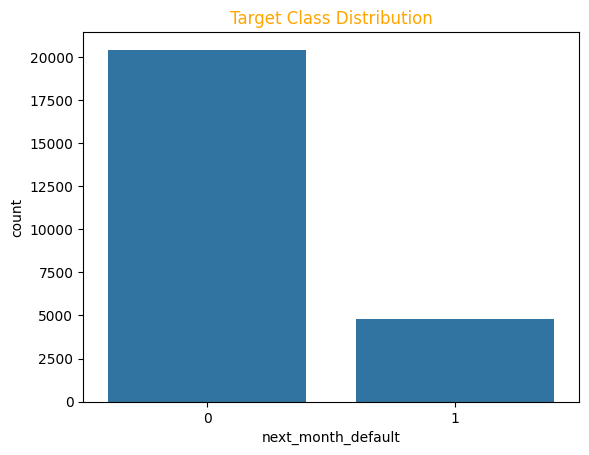

In [17]:
#EDA
# Target distribution
sns.countplot(x='next_month_default', data=train)
plt.title("Target Class Distribution",color='orange')
plt.show()

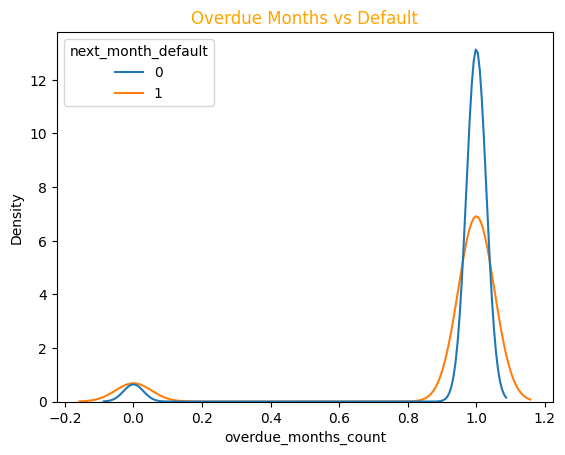

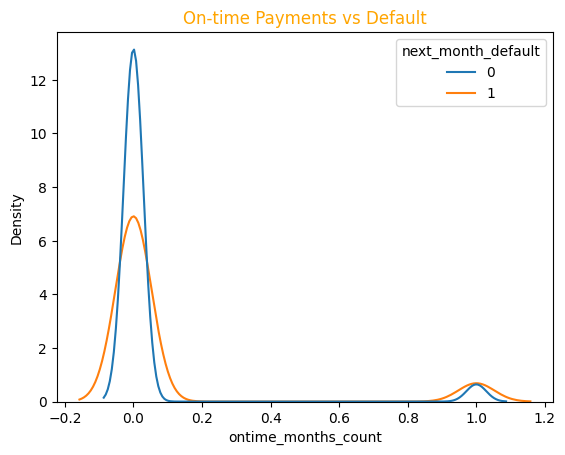

In [18]:
#Repayment Consistency (on-time payments vs overdue streaks)

pay_cols = [col for col in train.columns if col.startswith("PAY_")]

# Counting how many months the customer was overdue
train['overdue_months_count'] = train[pay_cols].apply(lambda row: sum(row > 0), axis=1)

# Counting how many months the customer paid on time or early 
train['ontime_months_count'] = train[pay_cols].apply(lambda row: sum(row <= 0), axis=1)

sns.kdeplot(data=train, x='overdue_months_count', hue='next_month_default', common_norm=False)
plt.title("Overdue Months vs Default",color='orange')
plt.show()

sns.kdeplot(data=train, x='ontime_months_count', hue='next_month_default', common_norm=False)
plt.title("On-time Payments vs Default",color='orange')
plt.show()

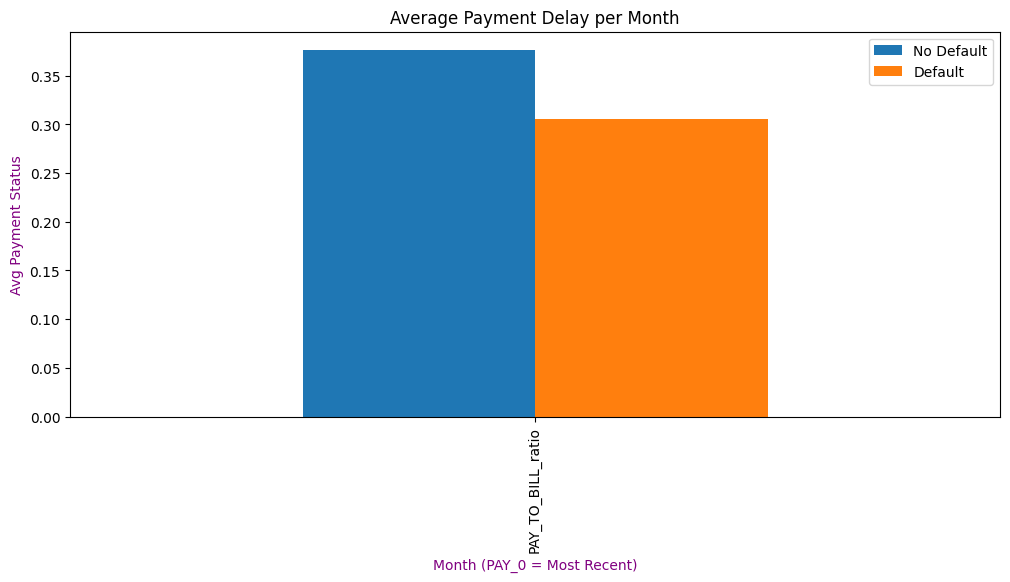

In [21]:
#Payment Delay Trend Across Months

avg_delays = train.groupby('next_month_default')[pay_cols].mean().T
avg_delays.columns = ['No Default', 'Default']
avg_delays.plot(kind='bar', figsize=(12, 5), title='Average Payment Delay per Month')
plt.ylabel("Avg Payment Status",color='purple')
plt.xlabel("Month (PAY_0 = Most Recent)",color='purple')
plt.show()

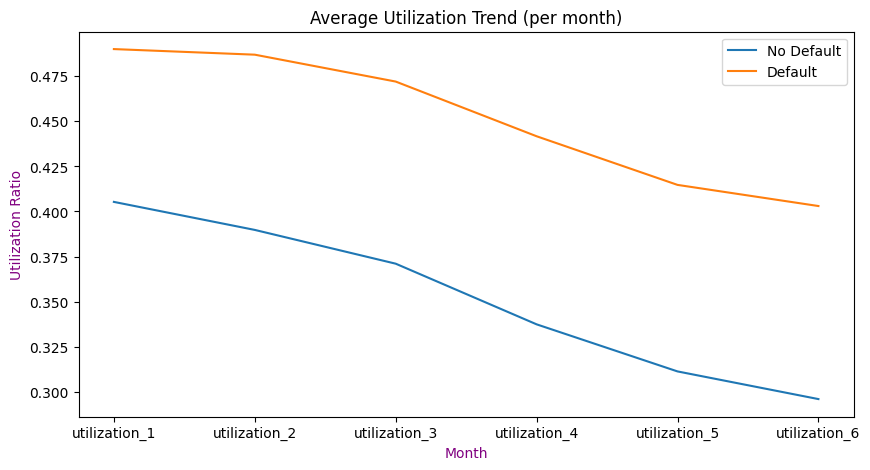

In [23]:
#Credit Utilization Trends

for i in range(1, 7):
    train[f'utilization_{i}'] = train[f'Bill_amt{i}'] / train['LIMIT_BAL']

util_cols = [f'utilization_{i}' for i in range(1, 7)]
utilization_trends = train.groupby('next_month_default')[util_cols].mean().T
utilization_trends.columns = ['No Default', 'Default']
utilization_trends.plot(title='Average Utilization Trend (per month)', figsize=(10, 5))
plt.ylabel("Utilization Ratio",color='purple')
plt.xlabel("Month",color='purple')
plt.show()

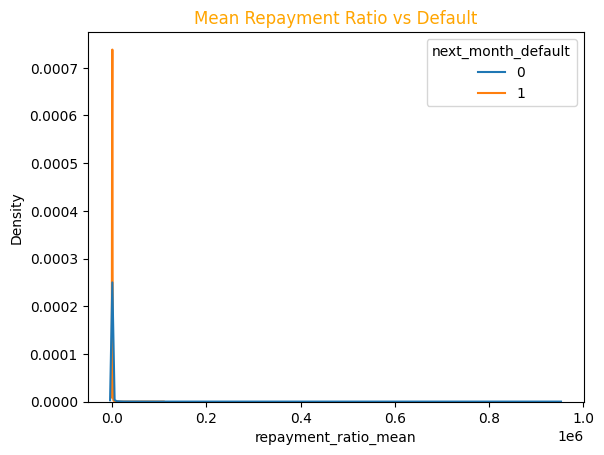

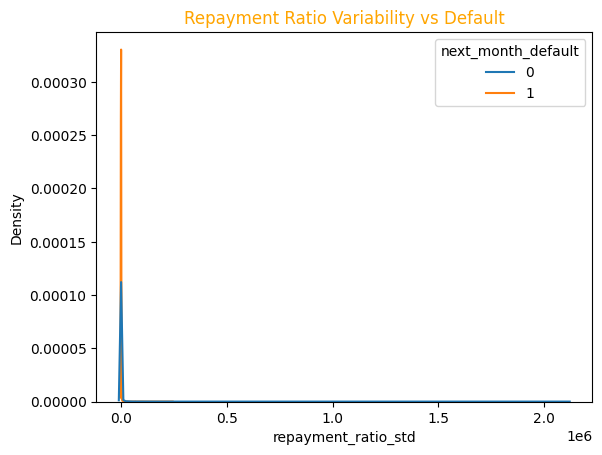

In [25]:
#Repayment Ratio Consistency
repayment_ratios = []
for i in range(1, 7):
    ratio = train[f'pay_amt{i}'] / train[f'Bill_amt{i}'].replace(0, np.nan)
    repayment_ratios.append(ratio.fillna(0))

train['repayment_ratio_mean'] = np.mean(repayment_ratios, axis=0)
train['repayment_ratio_std'] = np.std(repayment_ratios, axis=0)

# KDE plots
sns.kdeplot(data=train, x='repayment_ratio_mean', hue='next_month_default', common_norm=False)
plt.title("Mean Repayment Ratio vs Default",color='orange')
plt.show()

sns.kdeplot(data=train, x='repayment_ratio_std', hue='next_month_default', common_norm=False)
plt.title("Repayment Ratio Variability vs Default",color='orange')
plt.show()

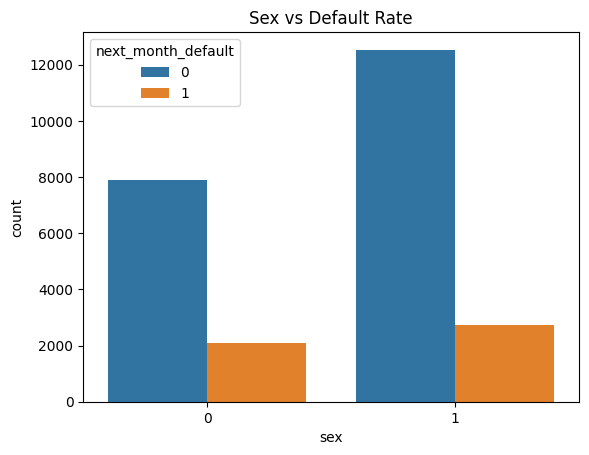

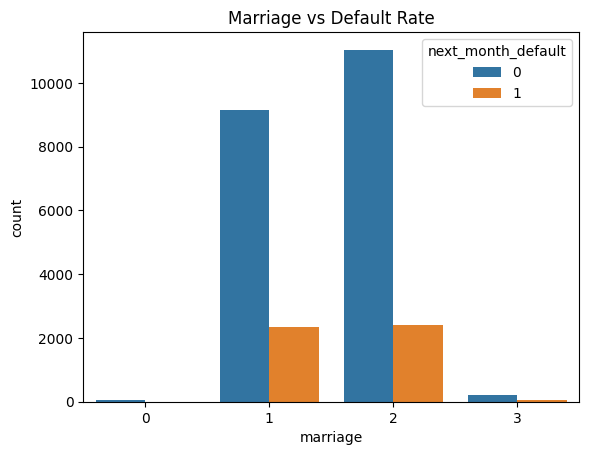

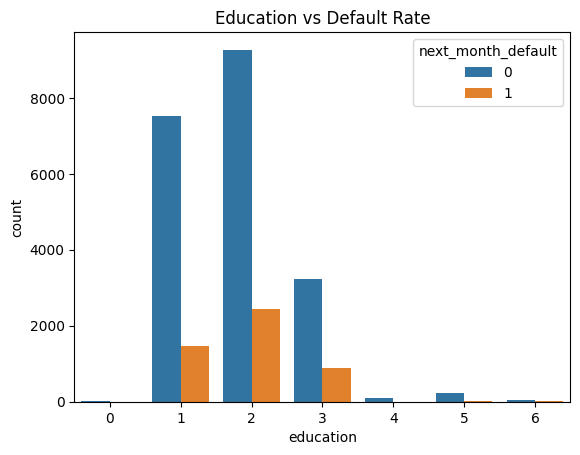

In [27]:
categorical_vars = ['sex', 'marriage', 'education']
for var in categorical_vars:
    sns.countplot(x=var, hue='next_month_default', data=train)
    plt.title(f'{var.capitalize()} vs Default Rate')
    plt.show()

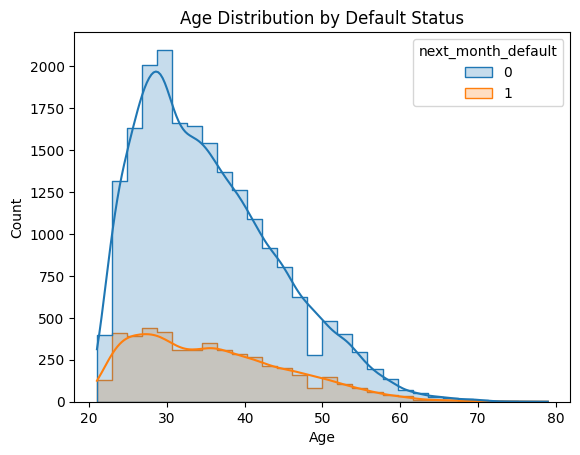

In [29]:
sns.histplot(data=train, x='age', hue='next_month_default', bins=30, kde=True, element="step")
plt.title("Age Distribution by Default Status")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()

In [51]:
#Feature Engineering
import numpy as np
from scipy.stats import linregress

def engineer_financial_features(df):
    df = df.copy()

    # Monthly Credit Utilization Ratios
    for i in range(1, 7):
        df[f'utilization_{i}'] = df[f'Bill_amt{i}'] / df['LIMIT_BAL']

    # Average and Std Dev of Utilization
    util_cols = [f'utilization_{i}' for i in range(1, 7)]
    df['avg_utilization'] = df[util_cols].mean(axis=1)
    df['std_utilization'] = df[util_cols].std(axis=1)

    pay_cols = ['pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6'] 
    
    # Delinquency Streak: Longest Consecutive Months with Delay
    def longest_streak(row):
        streak = 0
        max_streak = 0
        for val in row:
            if val > 0:
                streak += 1
                max_streak = max(max_streak, streak)
            else:
                streak = 0
        return max_streak

    df['longest_delay_streak'] = df[pay_cols].apply(longest_streak, axis=1)

    # Delay Trend Slope (linear regression over pay columns)
    def delay_slope(row):
        x = np.arange(len(row))
        return linregress(x, row).slope

    df['delay_trend_slope'] = df[pay_cols].apply(delay_slope, axis=1)

    # Repayment Ratios per Month: PAY_AMT / BILL_AMT
    for i in range(1, 7):
        df[f'payment_ratio_{i}'] = df[f'pay_amt{i}'] / df[f'Bill_amt{i}'].replace(0, np.nan)

    pay_ratios = [f'payment_ratio_{i}' for i in range(1, 7)]
    df['repayment_ratio_mean'] = df[pay_ratios].mean(axis=1)
    df['repayment_ratio_std'] = df[pay_ratios].std(axis=1)

    # Net Balance = Bill - Payment per Month
    for i in range(1, 7):
        df[f'net_balance_{i}'] = df[f'Bill_amt{i}'] - df[f'pay_amt{i}']

    net_balance_cols = [f'net_balance_{i}' for i in range(1, 7)]
    df['avg_net_balance'] = df[net_balance_cols].mean(axis=1)

    # Total Bill & Total Payment (6 months)
    df['total_bill'] = df[[f'Bill_amt{i}' for i in range(1, 7)]].sum(axis=1)
    df['total_pay'] = df[[f'pay_amt{i}' for i in range(1, 7)]].sum(axis=1)

    # PAY_TO_BILL Ratio
    df['PAY_TO_BILL_ratio'] = np.where(df['total_bill'] == 0, 0, df['total_pay'] / df['total_bill'])

    # Count of Overdue and On-time Months
    df['overdue_months_count'] = df[pay_cols].apply(lambda row: sum(row > 0), axis=1)
    df['ontime_months_count'] = df[pay_cols].apply(lambda row: sum(row <= 0), axis=1)

    return df

train = engineer_financial_features(train)
validation = engineer_financial_features(validation)

In [52]:
X = engineer_financial_features(train.drop(['Customer_ID', 'next_month_default'], axis=1))
y = train['next_month_default']
X = X.fillna(0)  # Handles NaNs from feature engineering


from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Spliting
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)


# SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)


In [70]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

model = XGBClassifier(eval_metric='logloss')
model.fit(X_train_res, y_train_res)

y_pred = model.predict(X_test)

In [55]:
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model.fit(X_train_res, y_train_res)

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print_color("Binary Classification",color='orange')
print_color("Confusion Matrix",color='purple')
print(confusion_matrix(y_test, y_pred))

print_color("\nClassification Report",color='purple')
print(classification_report(y_test, y_pred))

print("Accuracy :", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall   :", recall_score(y_test, y_pred))
print("F1 Score :", f1_score(y_test, y_pred))
print("AUC-ROC  :", roc_auc_score(y_test, y_prob))

[[3775  313]
 [ 583  379]]


              precision    recall  f1-score   support

           0       0.87      0.92      0.89      4088
           1       0.55      0.39      0.46       962

    accuracy                           0.82      5050
   macro avg       0.71      0.66      0.68      5050
weighted avg       0.81      0.82      0.81      5050

Accuracy : 0.8225742574257425
Precision: 0.5476878612716763
Recall   : 0.39397089397089397
F1 Score : 0.45828295042321643
AUC-ROC  : 0.7479433746557035


In [57]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced'),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42, class_weight='balanced'),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "LightGBM": LGBMClassifier(random_state=42)
}

In [71]:
def evaluate_model(name, model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else y_pred

    print_color(f"\n {name}",color='orange')
    print("Accuracy :", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall   :", recall_score(y_test, y_pred))
    print("F1 Score :", f1_score(y_test, y_pred))
    print("AUC-ROC  :", roc_auc_score(y_test, y_prob))
    print(classification_report(y_test, y_pred))

# Evaluate each model
for name, model in models.items():
    evaluate_model(name, model, X_train_res, y_train_res, X_test, y_test)

Accuracy : 0.6497029702970297
Precision: 0.28387787895018746
Recall   : 0.5509355509355509
F1 Score : 0.3746907034287734
AUC-ROC  : 0.6564588919040973
              precision    recall  f1-score   support

           0       0.86      0.67      0.76      4088
           1       0.28      0.55      0.37       962

    accuracy                           0.65      5050
   macro avg       0.57      0.61      0.57      5050
weighted avg       0.75      0.65      0.68      5050



Accuracy : 0.7356435643564356
Precision: 0.3410059676044331
Recall   : 0.4158004158004158
F1 Score : 0.3747072599531616
AUC-ROC  : 0.6133551981154721
              precision    recall  f1-score   support

           0       0.86      0.81      0.83      4088
           1       0.34      0.42      0.37       962

    accuracy                           0.74      5050
   macro avg       0.60      0.61      0.60      5050
weighted avg       0.76      0.74      0.75      5050



Accuracy : 0.8263366336633663
Precision: 0.5584594222833562
Recall   : 0.42203742203742206
F1 Score : 0.4807578448786264
AUC-ROC  : 0.7764288307952691
              precision    recall  f1-score   support

           0       0.87      0.92      0.90      4088
           1       0.56      0.42      0.48       962

    accuracy                           0.83      5050
   macro avg       0.71      0.67      0.69      5050
weighted avg       0.81      0.83      0.82      5050



Accuracy : 0.8225742574257425
Precision: 0.5476878612716763
Recall   : 0.39397089397089397
F1 Score : 0.45828295042321643
AUC-ROC  : 0.7479433746557035
              precision    recall  f1-score   support

           0       0.87      0.92      0.89      4088
           1       0.55      0.39      0.46       962

    accuracy                           0.82      5050
   macro avg       0.71      0.66      0.68      5050
weighted avg       0.81      0.82      0.81      5050

[LightGBM] [Info] Number of positive: 16352, number of negative: 16352
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.039716 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10805
[LightGBM] [Info] Number of data points in the train set: 32704, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Accuracy : 0.8304950495049505
Precision: 0.581039755351682
Recall   : 0.39501039501039503
F1 Score : 0.47029702970297027
AUC-ROC  : 0.7717621373443292
              precision    recall  f1-score   support

           0       0.87      0.93      0.90      4088
           1       0.58      0.40      0.47       962

    accuracy                           0.83      5050
   macro avg       0.72      0.66      0.68      5050
weighted avg       0.81      0.83      0.82      5050



In [63]:
Threshold tuning
from sklearn.metrics import fbeta_score, recall_score, precision_score, roc_auc_score

y_prob_test = model.predict_proba(X_test)[:, 1]

best_f2 = 0
best_threshold = 0.5

for t in [i / 100 for i in range(10, 91, 5)]:
    preds = (y_prob_test >= t).astype(int)
    f2 = fbeta_score(y_test, preds, beta=2)
    if f2 > best_f2:
        best_f2 = f2
        best_threshold = t

print(f" Best threshold based on F2: {best_threshold:.2f} (F2 = {best_f2:.2f})")


 Best threshold based on F2: 0.15 (F2 = 0.59)


In [74]:
#By applying threshold
from sklearn.metrics import recall_score, precision_score, fbeta_score, roc_auc_score

def evaluate_at_threshold(name, model, X_test, y_test, threshold=0.15):
    if hasattr(model, 'predict_proba'):
        y_prob = model.predict_proba(X_test)[:, 1]
    else:
        y_prob = model.predict(X_test)  # fallback for non-proba models

    y_pred_thresh = (y_prob >= threshold).astype(int)

    recall = recall_score(y_test, y_pred_thresh)
    precision = precision_score(y_test, y_pred_thresh)
    f2 = fbeta_score(y_test, y_pred_thresh, beta=2)
    auc = roc_auc_score(y_test, y_prob)

    print_color(f"\n{name}",color='orange')
    print(f"Threshold     : {threshold}")
    print(f"Recall        : {recall:.2f}")
    print(f"Precision     : {precision:.2f}")
    print(f"F2 Score      : {f2:.2f}")
    print(f"AUC-ROC       : {auc:.2f}")
for name, model in models.items():
    evaluate_at_threshold(name, model, X_test, y_test, threshold=0.15)

Threshold     : 0.15
Recall        : 0.98
Precision     : 0.20
F2 Score      : 0.55
AUC-ROC       : 0.66


Threshold     : 0.15
Recall        : 0.42
Precision     : 0.34
F2 Score      : 0.40
AUC-ROC       : 0.61


Threshold     : 0.15
Recall        : 0.90
Precision     : 0.26
F2 Score      : 0.60
AUC-ROC       : 0.78


Threshold     : 0.15
Recall        : 0.73
Precision     : 0.32
F2 Score      : 0.58
AUC-ROC       : 0.75


Threshold     : 0.15
Recall        : 0.81
Precision     : 0.28
F2 Score      : 0.59
AUC-ROC       : 0.77


In [81]:
# Prediction on the Unlabeled Validation Dataset
# Feature engineering )
validation = engineer_financial_features(validation)
X_val = validation.drop(columns=['Customer_ID'], errors='ignore').fillna(0)


In [82]:
model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    max_depth=4,
    learning_rate=0.1,
    n_estimators=100,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.5,
    reg_lambda=1,
    random_state=42
)
model.fit(X_train_res, y_train_res)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

In [86]:
X_val = X_val[X_train_res.columns]

val_probs = model.predict_proba(X_val)[:, 1]
print(val_probs[:20])  

[0.13203302 0.11753587 0.13683103 0.6125319  0.02108503 0.09385239
 0.45999134 0.06944374 0.10221191 0.14518438 0.17460717 0.17261875
 0.16918175 0.37135994 0.70981497 0.04454222 0.11345021 0.0602275
 0.10679667 0.1269148 ]


In [87]:
#Creating prediction file
val_preds = (val_probs >= 0.15).astype(int)

submission = pd.DataFrame({
    'Customer': validation['Customer_ID'],  
    'next_month_default': val_preds
})

submission.to_csv('submission_23125012.csv', index=False)
print("Submission file saved: submission_23125012.csv")

Submission file saved: submission_23125012.csv
